In [35]:
#ignoring warnings for readability
import warnings
warnings.filterwarnings('ignore')

In [36]:
import numpy as np
import pandas as pd

#helper functions to retrieve and load MNIST handwritten digits data set
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
    
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)

#Checking shape of mnist data and features
X,y = mnist["data"], mnist["target"]
print(mnist.data.shape, X.shape, y.shape)


(70000, 784) (70000, 784) (70000,)


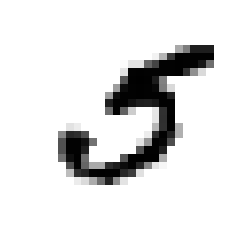

In [37]:
#plotting a sample digit
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [38]:
#Creating training and test sets with randomization

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(len(X_train), len(X_test), len(y_train), len(y_test))

shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
print(len(X_train), len(y_train))

60000 10000 60000 10000
60000 60000


In [39]:
#training a classifier to detect the digit "5" using a stochastic gradient descent classifier

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [40]:
#using cross validation for measuring model accuracy with stratified training sets and test sets.

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

0.9471
0.9602
0.9598


array([0.9471, 0.9602, 0.9598])

In [41]:
#model accuracy is also obviously high if we create a classifier that predicts every digit as "not 5"
#better options for model accuracy include sensitivity/specificity or f1 score

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) #removing 1 after len(X) gives the same output
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90985, 0.91005, 0.90905])

In [42]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
len(y_train_pred)

60000

In [43]:
#confusion matrix

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52928,  1651],
       [ 1007,  4414]], dtype=int64)

In [44]:
#perfectly classified confusion matrix

confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [45]:
#precision TP / (TP + FP) and recall scores TP / (TP + FN)
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred))

0.7277823577906019 0.8142409149603395


In [46]:
#f1 score, which weighs both precision and recall. Higher is better
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7685878460734807

In [47]:
 #decision for threshold (by default SGD Classifier threshold = 0) for classification
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 200000
y_scores > threshold

array([False])

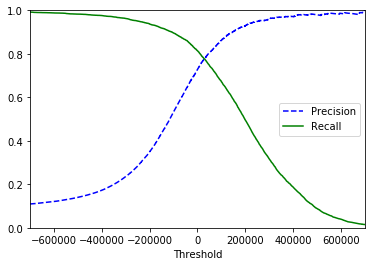

In [48]:
#choosing a decision threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method="decision_function")
len(y_scores) # 60,000

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper_left")
    plt.ylim([0,1])
    plt.xlim([-700000, 700000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [50]:
#Selecting a threshold with ~90% precision
y_train_90 = (y_scores > 160000)
print(precision_score(y_train_5, y_train_90), recall_score(y_train_5, y_train_90))

0.909809663250366 0.5731414868105515


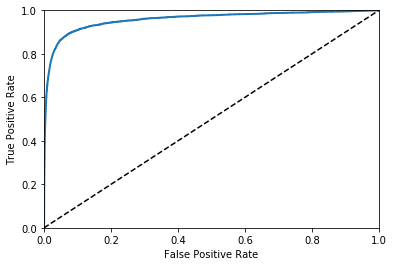

In [51]:
#ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

In [52]:
#AUC higher is better
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.958499055332093

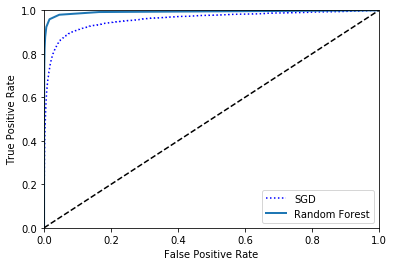

In [53]:
#training and measuring a random forest model 

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1] #probability of class = 5
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="Bottom Right")
plt.show()

In [54]:
roc_auc_score(y_train_5, y_scores_forest)

0.9926237379629802

In [55]:
#multiple classification
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [56]:
#Decision scores for numbers 0 to 9, target is 5
some_digit_scores = sgd_clf.decision_function([some_digit])
print(some_digit_scores, np.argmax(some_digit_scores))

[[-391382.95823803 -359269.20377229 -219750.0431359  -279506.47116422
  -356389.11296923  128608.82215453 -774739.38158077 -438219.59563968
  -681757.65653268 -477963.5842049 ]] 5


In [57]:
#Below shows correct classes only because the data set targets are 0 to 9
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [58]:
#One vs One classification
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state = 42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [59]:
#One vs One has to train 45 classifiers for this example: N * (N - 1) / 2
len(ovo_clf.estimators_)

45

In [60]:
#multiple class random forest classifier

forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0.1, 0. ]])

In [61]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring = "accuracy")

array([0.86552689, 0.88429421, 0.86763014])

In [62]:
#standardizing improves performance on the above RF classifer
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90891822, 0.90904545, 0.90888633])

In [63]:
#Error Analysis: finding out where model makes most mistakes
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5727,    4,   24,    9,   10,   53,   43,    8,   40,    5],
       [   1, 6474,   43,   20,    6,   38,    6,   11,  133,   10],
       [  54,   42, 5328,   94,   85,   28,   94,   63,  158,   12],
       [  44,   46,  140, 5313,    4,  245,   33,   60,  140,  106],
       [  22,   29,   34,    9, 5368,   11,   55,   29,   86,  199],
       [  68,   43,   35,  183,   67, 4625,  105,   29,  171,   95],
       [  31,   27,   41,    2,   42,   92, 5626,    6,   51,    0],
       [  23,   22,   74,   30,   55,    9,    6, 5779,   16,  251],
       [  50,  150,   69,  146,   18,  154,   56,   26, 5027,  155],
       [  39,   38,   28,   85,  168,   35,    2,  205,   79, 5270]],
      dtype=int64)

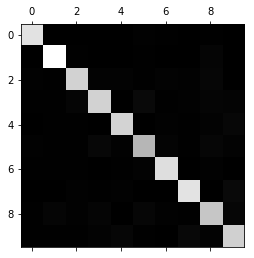

In [64]:
#doesn't look like many errors are made, but 5 is slightly darker
plt.matshow(conf_mx, cmap=plt.cm.gray)

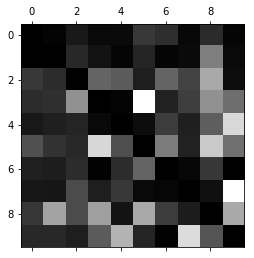

In [65]:
#looking at the errors on plot (Rows are actual class, columns are predictions)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() #looks like classes that are 3 and 9 are easily mistaken as 5 and 7 respectively (the whiter boxes)

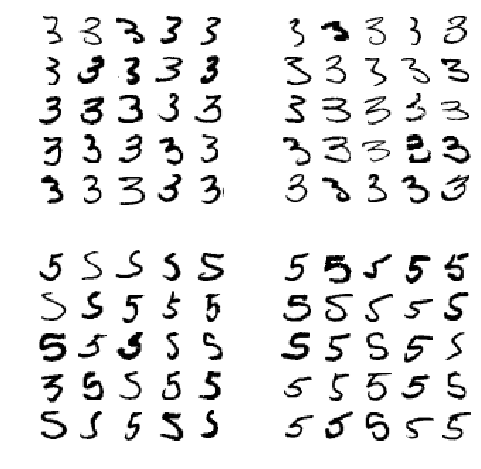

In [66]:
#plotting correctly and incorrectly predicted "3" and "5" digits to analyze what caused the error

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show() #left = 3's and 5's predicted as 3's. right = 5's and 3's predicted as 5's. 
#Pre-processing or a more complex model may help.

In [67]:
#multi-label classification using KNN

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [68]:
#Predicting if 5 is greater or equal to 7 and is odd
knn_clf.predict([some_digit])

array([[False,  True]])

In [73]:
#takes a long time to run, high f1 score (~96%)
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

#f1_score(y_train, y_train_knn_pred, average="macro")

0.9681228323874004

In [69]:
#multi-output classification using KNN 

#adding noise to data to show how the model can clean an image by predicting all 784 pixel intensities per instance
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

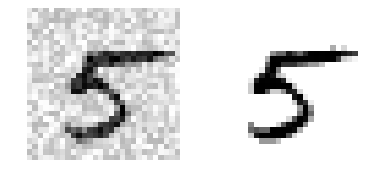

In [70]:
#digit with noise added and without
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

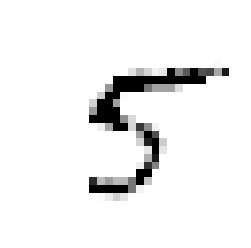

In [71]:
#KNN trained model predictions (784 pixel intensities)
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [74]:
#all 784 predictions
clean_digit

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 